Load tracks from file as nodes in network

In [47]:
import csv
import networkx as nx
import numpy as np

track_ids = np.load('tracks_with_genres.npy')
G = nx.Graph([])
track_names = []

#Add nodes and echonest features to graph
with open('fma_metadata/echonest.csv') as csvfile:
    csvreader = csv.reader(csvfile)
    
    #Skip headers
    next(csvreader)
    next(csvreader)
    next(csvreader)
    next(csvreader)
    
    n = 0
    lastSongTitle = ''
    
    #Iterate through tracks
    for row in csvreader:
        n += 1
        
        track_id = row[0]
        track_name = row[15]
        
        #Only add track if it is in the list of songs with a genre, take every 10 songs
        if (track_id in track_ids and track_name not in track_names):
            acousticness= float(row[1])
            danceability = float(row[2])
            energy = float(row[3])
            instrumentalness = float(row[4])
            liveliness = float(row[5])
            speechiness = float(row[6])
            tempo = float(row[7]) / 251 #normalize the tempos
            valence = float(row[8])

            G.add_node(track_id)
            G.nodes[track_id]['name'] = track_name
            G.nodes[track_id]['acousticness'] = acousticness
            G.nodes[track_id]['danceability'] = danceability
            G.nodes[track_id]['energy'] = energy
            G.nodes[track_id]['instrumentalness'] = instrumentalness
            G.nodes[track_id]['liveliness'] = liveliness
            G.nodes[track_id]['speechiness'] = speechiness
            G.nodes[track_id]['tempo'] = tempo
            G.nodes[track_id]['valence'] = valence
            G.nodes[track_id]['genre'] = ''
            
            track_names.append(track_name)
            
            
track_names.sort()
for track in track_names:
    print(track)
print('n:', len(G.nodes))

"Fresh Born" Covers
"I Stayed Home ..." (single)
"Killer Workout Mix" compilation
"M"
"rebukes!"
#3 for Bray Harp
(Köhn)1
1+e
1,000 Years
10 Acres of the Finest Sand
101
110211 - Lorenzo's Music - Local Love Fest - Live, High Noon Saloon
12 December 2007
15 Etudes
1Nation (One Remixx)
2005 Stayin Alive InstruMentals
2008 Sampler
20k9d
2205
25 Lessons in HYPNOTISM
2999
2999 (Mochipet)
3
3-song EP
30 Days
30th Anniversary Blah Blah Blah
42012
4a @ electric
4x4 Acid Stompers
50FOOTWAVE
6
6 Songs
7"
8 Bit Weapon Live at Micropalooza
@ ISSUE 10/22/09
A Banda de Joseph Tourton
A Flow of Code
A Life in a Day
A New Heavenly Body
A Peaky Blinder - Music Inspired by the Hit TV show
A Random Collection Of Consonants
A Real Life Travel Rep
A Retrospective 1990-2010 (set 1)
A Streams Area or: Watershed
A Struggle Not A Thought
A Tree Stump Named Desire
A2: What Should Have Been
ABBRACADAMN!!!
ABCDEFG-HIJKLMNOP-QRSTUV-WXYZ
AHX To Excess
AK Slaughter Unreleased Tracks
APB Live at WFMU on the Evan "Fu

Compute distances between the nodes and add edges if similarity is over some threshold

m: 136056
Mean similarity: 0.7509836554532124
Standard Deviation: 0.15852765871813543


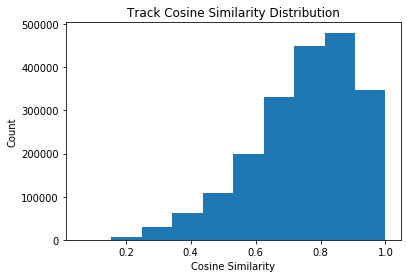

In [48]:
import numpy as np
import matplotlib.pyplot as plt

similarities = []
SIMILARITY_EDGE_THRESHOLD = 0.95

features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveliness', 'speechiness', 'valence', 'tempo']

#Compute Euclidean distance
def computeSongSimilarity(G, a, b):
    AB = 0
    AA = 0
    BB = 0

    for feature in features:
        featureA = G.nodes[a][feature]
        featureB = G.nodes[b][feature]

        AB += featureA * featureB
        AA += featureA ** 2
        BB += featureB ** 2

    sim = AB / (np.sqrt(AA)*np.sqrt(BB))

    return sim

#Iterate through nodes and add edges weighted by their distances
n = len(list(G.nodes))

for i in range(0, n):
    a = list(G.nodes)[i]
    for j in range(i+1, n):
        b = list(G.nodes)[j]
        
        similarity = computeSongSimilarity(G, a, b)
        similarities.append(similarity)
        
        #If songs are close, add an edge
        if(similarity > SIMILARITY_EDGE_THRESHOLD):
            G.add_edge(a, b)
    
print('m:', len(G.edges))
print('Mean similarity:', np.mean(similarities))
print('Standard Deviation:', np.std(similarities))

plt.hist(similarities)
plt.title('Track Cosine Similarity Distribution')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.show()
            

Look at the number of nodes within connected components

In [49]:
component_sizes = []

ones = 0

for component in nx.connected_components(G):
    component_sizes.append(len(component))
    if(len(component) == 10):
        print(component)
        for node in component:
            print(G.nodes[node]['genre'])
    if(len(component) == 1):
        ones += 1
        
    
print('Component sizes:', component_sizes)
#print('Ones:', ones)

n = len(G.nodes)
m = len(G.edges)

print('Network Density:', m/(n*(n-1)/2))




Component sizes: [2001, 1, 1, 1, 1, 1, 1]
Network Density: 0.06758796853087971


Set graph to be its largest connected component

In [50]:
largest_component = G.subgraph(list(nx.connected_components(G))[0])
                               
G = largest_component

Add genre labels and print out genre information

In [51]:
from collections import Counter

genres = []

with open('fma_metadata/tracks.csv') as csvfile:
    csvreader = csv.reader(csvfile)
    
    #Skip headers
    next(csvreader)
    next(csvreader)
    next(csvreader)
    
    nodes = G.nodes
    
    #If track is in our graph, label the node with the genre
    for row in csvreader:
        
        #Get track id and genre
        track_genre = row[40]
        track_id = row[0]
        
        #If track is in our graph, update its genre
        if (track_id in nodes):
            G.nodes[track_id]['genre'] = track_genre
            genres.append(track_genre)
            
print('Genres:(',len(set(genres)),')', '\n')

for i in range(len(set(genres))):
    print(list(Counter(genres).keys())[i], list(Counter(genres).values())[i])


Genres:( 12 ) 

Hip-Hop 139
Pop 87
Folk 184
Jazz 65
Rock 845
Electronic 412
International 29
Blues 12
Classical 79
Old-Time / Historic 124
Instrumental 23
Experimental 2


Compute Graph Modularity-Maximization Clusters

In [39]:
import time

def modCluster(G, k):
    
    clusters = [list(G.nodes)]
    p = 0
    #Until the graph is partitioned into k clusters
    while (len(clusters) < k):
        
        #Look for next partition to maximize modularity
        max_mod = 0
        max_clusters = clusters
        
        #Partition each component
        for cluster in clusters:
            ##print('Trying a cluster')
            g = G.subgraph(cluster)
            n = len(g.nodes)
            m = len(g.edges)
            
            #Compute modularity matrix
            B = np.zeros((n,n)) 
            for i in range(0,n):
                n1 = list(g.nodes)[i]
                B[i][i] = 1 - ((g.degree[n1]*g.degree[n1])/(2*m))
                for j in range(i + 1, n):
                    n2 = list(g.nodes)[j]
                    B[i][j] = int(g.has_edge(n1, n2)) - ((g.degree[n1]*g.degree[n2])/(2*m))
                    B[j][i] = B[i][j]

            #Find leading eigenvector u
            eigenvalues, eigenvectors = np.linalg.eig(B)
            leading_eigenvector = eigenvectors[:, list(eigenvalues).index(max(eigenvalues))]
            
            #Create clusters based on signs of eigenvector
            c1 = []
            c2 = []
            for i in range(0, n):
                if (leading_eigenvector[i] >= 0):
                    c1.append(list(g.nodes)[i])
                else:
                    c2.append(list(g.nodes)[i])
            
            #Generate potential clusters
            potential_clusters = list.copy(clusters)
            potential_clusters.remove(cluster)
            potential_clusters.append(c1)
            potential_clusters.append(c2)
            
            #Compute new graph modularity
            modularity = nx.algorithms.community.quality.performance(G, potential_clusters)
            
            #If modularity is better, set to max_graph
            if (modularity > max_mod):
                max_clusters = potential_clusters
                max_mod = modularity
            
        
        
        #Save new clustering
        clusters = max_clusters
        p += 1
        print(p, 'partitions')
        
    return clusters

start = time.clock()

mod_clusters = modCluster(G, 12)
np.save('modularity_max_clusters.npy', mod_clusters)

end = time.clock()

print('Time taken:', end - start)

/Users/joelbenson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


1 partitions
2 partitions
3 partitions
4 partitions
5 partitions
6 partitions
7 partitions
8 partitions
9 partitions
10 partitions
11 partitions
Time taken: 6782.053523000002


/Users/joelbenson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:72: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Compute Spectral Clusters

In [40]:
import time

def specCluster(G, k):
    
    clusters = [list(G.nodes)]
    p = 0
    
    #Until the graph is partitioned into k clusters
    while (len(clusters) < k):
        
        #Look for next partition to maximize modularity
        max_mod = 0
        max_clusters = clusters
        
        #Partition each component
        for cluster in clusters:
            ##print('Trying a cluster')
            g = G.subgraph(cluster)
            n = len(g.nodes)
            m = len(g.edges)
            
            #Compute graph Laplacian matrix
            L = np.zeros((n,n)) 
            for i in range(0,n):
                n1 = list(g.nodes)[i]
                L[i][i] = g.degree[n1]
                for j in range(i + 1, n):
                    n2 = list(g.nodes)[j]
                    L[i][j] = -int(g.has_edge(n1, n2))
                    L[j][i] = L[i][j]

            #Find second smallest eigenvector u
            eigenvalues, eigenvectors = np.linalg.eig(L)
            
            eigenpairs = []
            for i in range(len(eigenvalues)):
                eigenpairs.append((eigenvalues[i], eigenvectors[:, i]))
            eigenpairs.sort(key=lambda x: x[0])
            second_eigenvector = eigenpairs[1][1]
            
            #Create clusters based on signs of eigenvector
            c1 = []
            c2 = []
            for i in range(0, n):
                if (second_eigenvector[i] >= 0):
                    c1.append(list(g.nodes)[i])
                else:
                    c2.append(list(g.nodes)[i])
            
            #Generate potential clusters
            potential_clusters = list.copy(clusters)
            potential_clusters.remove(cluster)
            potential_clusters.append(c1)
            potential_clusters.append(c2)
            
            #Compute new graph modularity
            modularity = nx.algorithms.community.quality.performance(G, potential_clusters)
            
            #If modularity is better, set to max_graph
            if (modularity > max_mod):
                max_clusters = potential_clusters
                max_mod = modularity
            
        #Save new clustering
        clusters = max_clusters
        p += 1
        print(p, 'partitions')
        
    return clusters

start = time.clock()

spectral_clusters = specCluster(G, 12)
np.save('spectral_clusters.npy', spectral_clusters)

end = time.clock()

print('Time taken:', end - start)

/Users/joelbenson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


1 partitions
2 partitions
3 partitions
4 partitions
5 partitions
6 partitions
7 partitions
8 partitions
9 partitions
10 partitions
11 partitions
Time taken: 16360.399522


/Users/joelbenson/.local/lib/python3.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Compute Betweenness Clusters (Takes too long)

Print Mod Clusters

In [41]:
mod_clusters = np.load('modularity_max_clusters.npy', allow_pickle=True)
for cluster in mod_clusters:
    print(cluster,'\n')


['50608', '6963', '24477', '32176', '12058', '116563', '54064', '814', '16036', '18689', '18817', '15893', '42455', '20086', '74925', '27860', '11350', '3225', '43149', '31119', '1279', '11418', '3514', '24460', '3707', '1116', '112313', '62582', '16337', '3270', '7011', '16045', '9887', '11738', '11374', '68341', '11757', '19667', '28803', '16398', '16351', '27366', '1544', '116454', '5106', '5011', '304', '16061', '46610', '32800', '15036', '42527', '11715', '3880', '3882', '46756', '37725', '10363', '1020', '25735', '1675', '1701', '31143', '5156', '16987', '16421', '41566', '610', '11976', '8565', '16989', '12022', '37329', '4018', '13646', '9474', '20126', '11346', '5017', '16277', '10975', '11323', '17440', '1305', '17987', '28549', '853', '11695', '16513', '20152', '19582', '4799', '26469', '22081', '1975', '11750', '21087', '1694', '65782', '41961', '15627', '17711', '19636', '178', '48539', '213', '3556', '34541', '97903', '39531', '116549', '11349', '11503', '6779', '13455', 

Print Spectral Clusters

In [42]:
spectral_clusters = np.load('spectral_clusters.npy', allow_pickle=True)
for cluster in spectral_clusters:
    print(cluster,'\n')

['190', '3367', '3810', '4790', '5047', '7493', '10100', '10621', '12367', '13735', '17132', '24173', '24792', '28594', '32325', '33538', '40265', '41971', '46926', '51119', '51331', '53937', '57810', '58614', '83813', '85968', '105713', '107617', '112369', '123469'] 

['169', '604', '847', '1474', '3586', '3598', '3602', '3876', '4991', '5016', '5019', '5023', '5024', '5026', '5027', '5028', '5029', '5031', '5033', '5035', '5037', '5038', '5040', '5041', '5042', '5275', '6363', '6460', '10033', '10087', '10088', '10090', '10092', '10093', '10094', '10095', '10096', '10097', '10098', '10099', '10103', '10104', '10356', '10357', '10360', '10364', '10367', '10368', '11319', '11346', '11347', '11733', '11737', '12109', '12922', '13191', '13761', '14733', '15357', '16036', '16342', '16354', '16396', '16511', '16513', '16949', '17623', '18040', '19073', '19215', '19680', '21410', '21798', '22552', '25701', '25922', '25928', '27547', '30131', '31819', '35734', '42648', '43367', '44805', '476

Save cluster labels to our graph

In [52]:
mod_clusters = np.load('modularity_max_clusters.npy', allow_pickle=True)
spectral_clusters = np.load('spectral_clusters.npy', allow_pickle=True)

#Iterate through the clusters and nodes, and set attributes for the nodes contained within each cluster
#Modularity Clusters
for i in range(0,len(mod_clusters)):
    for node in G.nodes:
        if (node in mod_clusters[i]):
            G.nodes[node]['modCluster'] = i
        
#Spectral Clusters
for i in range(0,len(spectral_clusters)):
    for node in G.nodes:
        if (node in spectral_clusters[i]):
            G.nodes[node]['spectralCluster'] = i


Save graph to GML File

In [53]:
nx.write_gml(G, 'GMLNetworkFiles/musicNetwork.gml')

Save each genre to a GML File

In [54]:
genre_clusters = [[],[],[],[],[],[],[],[],[],[],[],[]]

#Save nodes to group by genre
for node in G.nodes:
    if (G.nodes[node]['genre'] == 'Jazz'):
        genre_clusters[0].append(node)
    elif (G.nodes[node]['genre'] == 'Rock'):
        genre_clusters[1].append(node)
    elif (G.nodes[node]['genre'] == 'Folk'):
        genre_clusters[2].append(node)
    elif (G.nodes[node]['genre'] == 'Electronic'):
        genre_clusters[3].append(node)
    elif (G.nodes[node]['genre'] == 'Hip-Hop'):
        genre_clusters[4].append(node)
    elif (G.nodes[node]['genre'] == 'Pop'):
        genre_clusters[5].append(node)
    elif (G.nodes[node]['genre'] == 'International'):
        genre_clusters[6].append(node)
    elif (G.nodes[node]['genre'] == 'Blues'):
        genre_clusters[7].append(node)
    elif (G.nodes[node]['genre'] == 'Classical'):
        genre_clusters[8].append(node)
    elif (G.nodes[node]['genre'] == 'Old-Time / Historic'):
        genre_clusters[9].append(node)
    elif (G.nodes[node]['genre'] == 'Instrumental'):
        genre_clusters[10].append(node)
    elif (G.nodes[node]['genre'] == 'Experimental'):
        genre_clusters[11].append(node)
        
#Save clusters
np.save('genre_clusters.npy', genre_clusters)

#Save genres to GML files
nx.write_gml((G.subgraph(genre_clusters[0])), 'GMLNetworkFiles/jazz.gml')
nx.write_gml((G.subgraph(genre_clusters[1])), 'GMLNetworkFiles/rock.gml')
nx.write_gml((G.subgraph(genre_clusters[2])), 'GMLNetworkFiles/folk.gml')
nx.write_gml((G.subgraph(genre_clusters[3])), 'GMLNetworkFiles/electronic.gml')
nx.write_gml((G.subgraph(genre_clusters[4])), 'GMLNetworkFiles/hip-hop.gml')
nx.write_gml((G.subgraph(genre_clusters[5])), 'GMLNetworkFiles/pop.gml')
nx.write_gml((G.subgraph(genre_clusters[6])), 'GMLNetworkFiles/international.gml')
nx.write_gml((G.subgraph(genre_clusters[7])), 'GMLNetworkFiles/blues.gml')
nx.write_gml((G.subgraph(genre_clusters[8])), 'GMLNetworkFiles/classical.gml')
nx.write_gml((G.subgraph(genre_clusters[9])), 'GMLNetworkFiles/old-time-historic.gml')
nx.write_gml((G.subgraph(genre_clusters[10])), 'GMLNetworkFiles/instrumental.gml')
nx.write_gml((G.subgraph(genre_clusters[11])), 'GMLNetworkFiles/experimental.gml')

Compute Modularity Scores for the Resulting Clusters

In [55]:
mod_clusters = np.load('modularity_max_clusters.npy', allow_pickle=True)
spectral_clusters = np.load('spectral_clusters.npy', allow_pickle=True)
genre_clusters = np.load('genre_clusters.npy', allow_pickle=True)


genre_modularity_score = nx.algorithms.community.quality.performance(G, genre_clusters)
mod_modularity_score = nx.algorithms.community.quality.performance(G, mod_clusters)
spec_modularity_score = nx.algorithms.community.quality.performance(G, spectral_clusters)

print('True genre modularity:', genre_modularity_score)
print('Modularity maximization modularity:', mod_modularity_score)
print('Spectral clustering modularity:', spec_modularity_score)

True genre modularity: 0.7409910044977511
Modularity maximization modularity: 0.9192098950524737
Spectral clustering modularity: 0.5878505747126437
